In [1]:
# Import data from Excel sheet
import pandas as pd
#df = pd.read_excel('/content/drive/My Drive/ADNI_komplett/ADNI combined.xlsx', sheet_name='sample')
df = pd.read_excel('hippocampus_volume_relevance_ADNI2.xlsx', sheet_name='ADNI2_LRP_CMP')
#print(df)
sid = df['subject_ID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV_CAT12']
field = df['MRI_Field_Strength']
amybin = df['Amy SUVR Pos']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAD = sorted(glob.glob('mwp1_MNI/AD/*.nii.gz'))
dataLMCI = sorted(glob.glob('mwp1_MNI/LMCI/*.nii.gz'))
dataCN = sorted(glob.glob('mwp1_MNI/CN/*.nii.gz'))
dataFiles = dataAD + dataLMCI + dataCN
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  663  nifti files


In [3]:
# Match covariate information
import re
import numpy as np
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]
amy_status = pd.DataFrame({'amy_pos':amybin}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
hf = h5py.File('residuals_ADNI2_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()
print(images.shape)

(663, 100, 100, 120, 1)


In [5]:
# determine amyloid status
amy_filter = np.equal(np.transpose(amy_status.to_numpy()), labels[:,1])


In [6]:
# specify version of tensorflow
#%tensorflow_version 1.x  # <- use this for Google colab
import tensorflow as tf
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

1.15.4


In [7]:
# set predefined test indices from 20fold xval
test_indices = [np.array([  2, 3, 8, 26, 31, 49, 62, 74, 77, 80, 86, 90, 127, 136, 143, 144, 148, 170,
                185, 206, 210, 223, 227, 229, 233, 262, 272, 280, 281, 301, 307, 310, 312, 314, 315, 335,
                346, 351, 367, 395, 406, 422, 426, 446, 449, 452, 459, 485, 491, 494, 495, 507, 518, 535,
                540, 549, 559, 575, 586, 588, 590, 601, 625, 630, 639, 646, 655]),
                np.array([ 18, 23, 28, 38, 44, 48, 55, 68, 70, 78, 81, 98, 102, 103, 120, 135, 162, 167,
                182, 192, 199, 205, 231, 239, 242, 245, 247, 253, 261, 265, 275, 279, 287, 293, 299, 316,
                336, 348, 377, 378, 405, 432, 437, 442, 458, 469, 473, 478, 479, 482, 498, 513, 516, 525,
                536, 543, 545, 562, 564, 569, 570, 604, 606, 613, 616, 634, 638]),
                np.array([  6, 12, 14, 24, 47, 50, 56, 64, 96, 99, 108, 114, 121, 129, 133, 155, 157, 160,
                171, 190, 194, 200, 204, 211, 213, 216, 224, 254, 259, 266, 273, 277, 283, 286, 296, 303,
                338, 342, 387, 393, 407, 409, 413, 417, 423, 438, 443, 445, 454, 457, 464, 477, 501, 504,
                515, 517, 522, 527, 551, 571, 573, 574, 622, 626, 647, 653, 656]),
                np.array([  4, 10, 15, 20, 36, 41, 43, 93, 95, 118, 119, 124, 145, 149, 154, 159, 163, 179,
                183, 202, 203, 208, 212, 219, 221, 235, 246, 251, 255, 269, 302, 304, 308, 325, 328, 354,
                369, 376, 383, 392, 398, 410, 415, 416, 419, 433, 440, 455, 466, 502, 512, 546, 561, 565,
                583, 587, 603, 605, 607, 612, 618, 624, 633, 637, 651, 654]),
                np.array([  7, 33, 42, 60, 61, 66, 105, 106, 107, 110, 111, 115, 134, 138, 139, 142, 161, 178,
                186, 195, 196, 197, 215, 228, 236, 238, 241, 260, 278, 285, 292, 297, 320, 347, 353, 360,
                363, 368, 371, 374, 401, 420, 424, 429, 430, 435, 447, 465, 472, 476, 489, 490, 531, 541,
                552, 555, 556, 585, 635, 636, 640, 645, 648, 657, 661, 662]),
                np.array([  5, 29, 35, 39, 40, 51, 53, 65, 69, 75, 94, 97, 128, 137, 156, 175, 176, 184,
                188, 214, 226, 232, 237, 264, 276, 282, 289, 294, 300, 305, 330, 343, 356, 370, 375, 380,
                389, 391, 402, 403, 404, 436, 463, 471, 474, 480, 481, 483, 492, 499, 503, 508, 523, 528,
                534, 554, 563, 567, 582, 596, 620, 642, 643, 644, 658, 659]),
                np.array([  9, 11, 16, 19, 45, 52, 54, 71, 72, 73, 79, 84, 87, 109, 147, 166, 173, 177,
                180, 201, 209, 217, 222, 244, 250, 252, 258, 267, 306, 311, 318, 323, 327, 333, 337, 350,
                366, 372, 373, 379, 390, 411, 412, 414, 427, 428, 431, 439, 448, 456, 484, 488, 509, 514,
                532, 538, 547, 557, 566, 572, 577, 580, 584, 608, 621, 660]),
                np.array([ 22, 27, 37, 82, 83, 88, 89, 92, 100, 101, 104, 116, 122, 123, 126, 131, 151, 172,
                174, 189, 207, 234, 240, 243, 248, 256, 271, 309, 319, 321, 324, 326, 334, 344, 349, 357,
                358, 362, 365, 385, 386, 418, 453, 461, 462, 468, 475, 500, 505, 511, 537, 539, 548, 578,
                594, 597, 599, 610, 611, 617, 619, 623, 627, 628, 629, 652]),
                np.array([  1, 13, 17, 21, 30, 32, 34, 46, 57, 58, 91, 113, 130, 140, 146, 150, 152, 164,
                168, 191, 193, 218, 220, 230, 249, 263, 270, 284, 288, 298, 313, 317, 322, 339, 345, 361,
                382, 384, 397, 399, 408, 425, 434, 441, 450, 451, 467, 470, 493, 506, 519, 520, 521, 524,
                529, 530, 544, 558, 568, 576, 589, 591, 600, 609, 615, 649]),
                np.array([  0, 25, 59, 63, 67, 76, 85, 112, 117, 125, 132, 141, 153, 158, 165, 169, 181, 187,
                198, 225, 257, 268, 274, 290, 291, 295, 329, 331, 332, 340, 341, 352, 355, 359, 364, 381,
                388, 394, 396, 400, 421, 444, 460, 486, 487, 496, 497, 510, 526, 533, 542, 550, 553, 560,
                579, 581, 592, 593, 595, 598, 602, 614, 631, 632, 641, 650])]
print(len(test_indices))

10


In [8]:
# helper function to obtain performance result values
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((ppv * sen) / (ppv + sen))
    bacc = (spec + sen) / 2
    return bacc, sen, spec, ppv, npv, f1

[5165, 5187, 101, 1010, 5146, 378, 5056, 230, 4990, 4373, 4568, 4657, 4660, 4692, 4863, 4984, 307, 150, 671, 1269, 4034, 4035, 4287, 4303, 4346, 4359, 4363, 4510, 4595, 4105, 96, 56, 5023, 352, 89, 1261, 4075, 4103, 4224, 4337, 4382, 4410, 4464, 4576, 4585]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
4    16
1    16
3    13
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv1.best.hdf5


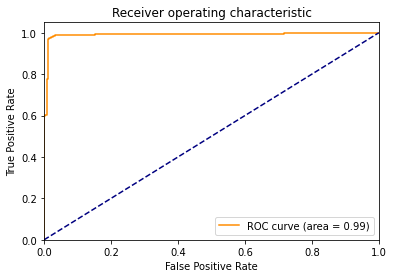

AUC for MCI vs. CN = 0.986
AUC for AD vs. CN = 0.995
Acc for MCI vs. CN = 97.3
Acc for AD vs. CN = 98.2
confusion matrix
[[249   5]
 [  8 212]
 [  3 186]]
[702, 5251, 906, 5063, 5062, 269, 51, 4992, 5058, 873, 1255, 6142, 4252, 4549, 4783, 4827, 4954, 1046, 4945, 5047, 1300, 123, 1414, 1186, 4030, 4131, 4197, 4366, 4515, 4955, 1016, 4050, 260, 301, 668, 6051, 4021, 4093, 4148, 4269, 4367, 4483, 4505, 4516, 4599]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
4    17
1    15
3    13
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv2.best.hdf5


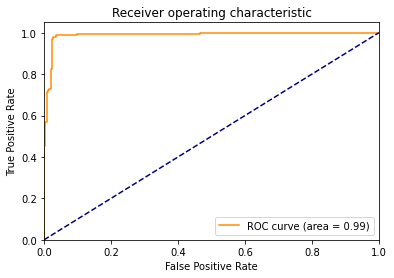

AUC for MCI vs. CN = 0.981
AUC for AD vs. CN = 0.996
Acc for MCI vs. CN = 97.0
Acc for AD vs. CN = 98.2
confusion matrix
[[247   7]
 [  7 213]
 [  1 188]]
[5119, 5037, 5252, 552, 5070, 5090, 5015, 4089, 4195, 4258, 4477, 4526, 4772, 4867, 4922, 644, 4729, 454, 4250, 717, 4015, 4053, 4061, 4169, 4240, 4524, 4562, 4857, 4976, 4213, 4872, 1206, 4097, 934, 4234, 896, 657, 186, 4032, 4043, 4121, 4369, 4372, 4376, 4559, 4649, 4832]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    18
3    15
4    14
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv3.best.hdf5


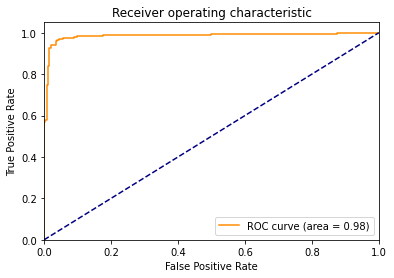

AUC for MCI vs. CN = 0.977
AUC for AD vs. CN = 0.994
Acc for MCI vs. CN = 94.3
Acc for AD vs. CN = 98.2
confusion matrix
[[249   5]
 [ 22 198]
 [  3 186]]
[572, 1030, 6303, 1326, 830, 5087, 997, 5059, 4215, 4307, 4672, 4696, 4730, 4770, 4912, 4962, 4985, 142, 6356, 4203, 4714, 1380, 4167, 1419, 778, 4243, 4414, 4444, 4646, 4736, 4815, 4888, 4904, 610, 498, 171, 113, 4037, 4084, 4275, 4340, 4349, 4393, 4401, 4469, 4485, 4503, 4545, 4598, 4609, 4762, 4835]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    19
3    17
4    16
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv4.best.hdf5


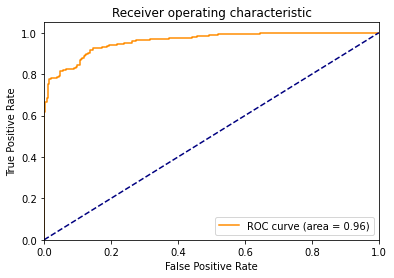

AUC for MCI vs. CN = 0.932
AUC for AD vs. CN = 0.990
Acc for MCI vs. CN = 82.3
Acc for AD vs. CN = 94.8
confusion matrix
[[243  11]
 [ 73 147]
 [ 12 177]]
[1130, 4859, 4968, 5184, 4024, 4039, 4152, 4153, 4201, 4546, 4589, 4591, 4641, 4774, 4911, 5012, 6258, 1218, 4311, 296, 4542, 4058, 4170, 4596, 4636, 4689, 4713, 4743, 4757, 4925, 419, 58, 120, 59, 272, 969, 1195, 4173, 4308, 4313, 4399, 4604, 4607, 4620, 4856, 4951, 4952]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    17
4    16
3    14
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv5.best.hdf5


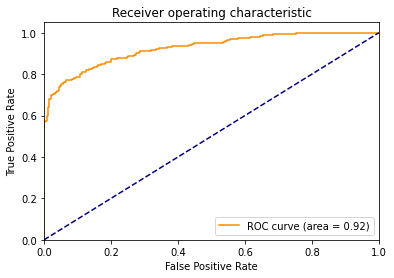

AUC for MCI vs. CN = 0.878
AUC for AD vs. CN = 0.980
Acc for MCI vs. CN = 79.1
Acc for AD vs. CN = 91.4
confusion matrix
[[227  27]
 [ 72 148]
 [ 11 178]]
[887, 4964, 5013, 5017, 4980, 1346, 5029, 667, 6039, 5231, 5275, 4583, 4737, 4905, 4906, 4982, 5019, 4804, 919, 800, 1268, 4042, 4458, 4582, 4793, 4885, 4929, 4936, 4943, 618, 722, 767, 1280, 4041, 4076, 4125, 4177, 4292, 4345, 4352, 4391, 4441, 4555, 4637, 4638, 4643, 4878, 4900]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    19
4    17
3    12
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv6.best.hdf5


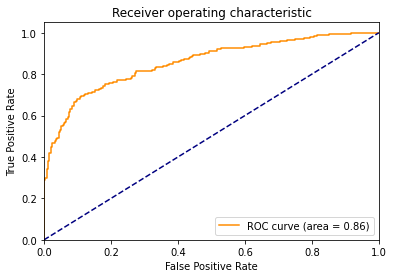

AUC for MCI vs. CN = 0.782
AUC for AD vs. CN = 0.943
Acc for MCI vs. CN = 72.2
Acc for AD vs. CN = 87.8
confusion matrix
[[222  32]
 [100 120]
 [ 22 167]]
[5196, 5027, 5071, 1117, 5112, 5005, 4959, 4994, 5106, 166, 5028, 1043, 4136, 4686, 4820, 4887, 4910, 4940, 6073, 1063, 4899, 925, 4928, 4263, 4324, 4406, 4430, 4502, 4521, 4721, 4746, 4877, 907, 981, 553, 926, 741, 172, 21, 413, 4080, 4090, 4218, 4276, 4350, 4388, 4396, 4488, 4558, 4921]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
4    18
1    18
3    14
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv7.best.hdf5


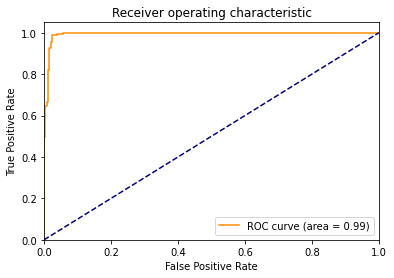

AUC for MCI vs. CN = 0.987
AUC for AD vs. CN = 0.998
Acc for MCI vs. CN = 97.3
Acc for AD vs. CN = 98.0
confusion matrix
[[245   9]
 [  4 216]
 [  0 189]]
[331, 214, 5095, 5123, 4971, 5006, 994, 1004, 4001, 4209, 4282, 4353, 4500, 4718, 4879, 4894, 1106, 709, 1246, 4294, 4402, 4408, 4507, 4584, 4611, 4668, 4712, 4720, 4852, 751, 4208, 69, 1286, 4028, 4060, 4082, 4200, 4222, 4446, 4449, 4496, 4499, 4520, 4552, 4560, 4579, 4580, 4795]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    19
4    16
3    13
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv8.best.hdf5


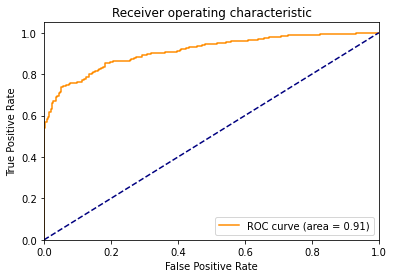

AUC for MCI vs. CN = 0.856
AUC for AD vs. CN = 0.976
Acc for MCI vs. CN = 77.4
Acc for AD vs. CN = 93.7
confusion matrix
[[241  13]
 [ 94 126]
 [ 15 174]]
[1057, 5224, 658, 5032, 5120, 5054, 835, 5210, 4997, 4192, 4494, 4615, 4707, 4719, 4801, 4845, 1074, 989, 4189, 4057, 4079, 4171, 4377, 4403, 4531, 4590, 4807, 4903, 4909, 984, 74, 923, 5040, 315, 680, 4066, 4104, 4119, 4139, 4158, 4164, 4357, 4384, 4421, 4424, 4453, 4491]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    18
4    16
3    13
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv9.best.hdf5


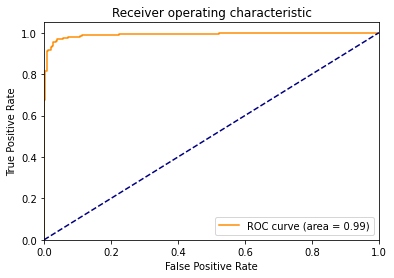

AUC for MCI vs. CN = 0.985
AUC for AD vs. CN = 0.998
Acc for MCI vs. CN = 94.9
Acc for AD vs. CN = 97.5
confusion matrix
[[247   7]
 [ 17 203]
 [  4 185]]
[729, 5205, 5016, 160, 361, 227, 4211, 4501, 4625, 4728, 4756, 4802, 4853, 4949, 5018, 698, 4302, 285, 1378, 4096, 4114, 4162, 4456, 4462, 4489, 4538, 4631, 4675, 4715, 4892, 4902, 4918, 1352, 47, 311, 4018, 4020, 4150, 4254, 4279, 4387, 4389, 4427, 4428, 4448, 4466, 4506, 4586, 4632, 4739]
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    18
3    17
4    15
Name: Group, dtype: int64
validating model: model_checkpoints/resmodel_wb_cv10.best.hdf5


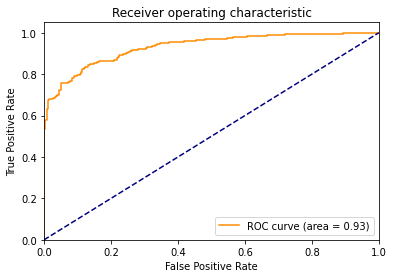

AUC for MCI vs. CN = 0.891
AUC for AD vs. CN = 0.978
Acc for MCI vs. CN = 80.4
Acc for AD vs. CN = 90.7
confusion matrix
[[225  29]
 [ 64 156]
 [ 12 177]]


In [10]:
# validation
import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import models
import tensorflow as tf
from sklearn.metrics import confusion_matrix

acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
bacc_AD, bacc_MCI = [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
f1_AD, f1_MCI = [], []


batch_size = 20
k = 1
for test_idX in test_indices: # use existing split from training cross-validation
    test_idX = test_idX[np.squeeze(amy_filter)[test_idX]] # filter index vector by amy status
    testgrps = grps.iloc[test_idX, :]
    print(list(testgrps.RID)) # print test RIDs
    print('Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())
    
    testdat = images[test_idX, :]
    test_Y = labels[test_idX, :]

    print('validating model: model_checkpoints/resmodel_wb_cv%d.best.hdf5' % k)
    mymodel = models.load_model('model_checkpoints/resmodel_wb_cv%d.best.hdf5' % k)
    k = k+1

    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(images, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [3,4]:
      grpi = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      acc[i] = np.mean((labels[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100

    print('AUC for MCI vs. CN = %0.3f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[4])
    print('Acc for MCI vs. CN = %0.1f' % acc[3])
    print('Acc for AD vs. CN = %0.1f' % acc[4])
    auc_AD.append(roc_auc[4])
    auc_MCI.append(roc_auc[3])
    acc_AD.append(acc[4])
    acc_MCI.append(acc[3])
    
    print('confusion matrix')
    confmat = confusion_matrix(grps.Group, np.round(pred[:, 1]))
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(1,2),0:2]) # MCI
    bacc_MCI.append(bacc); sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(1,3),0:2]) # AD
    bacc_AD.append(bacc); sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[1:4,0:2])

In [11]:
# print model performance summary
from statistics import mean,stdev

print('Mean AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('Mean AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.3f +/- %0.3f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean Bacc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(bacc_MCI), stdev(bacc_MCI)))
print('Mean Bacc for AD vs. CN = %0.3f +/- %0.3f' % (mean(bacc_AD), stdev(bacc_AD)))
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))

Mean AUC for MCI vs. CN = 0.925 +/- 0.071
Mean AUC for AD vs. CN = 0.985 +/- 0.017
Mean Acc for MCI vs. CN = 87.215 +/- 9.819
Mean Acc for AD vs. CN = 94.853 +/- 3.799
Mean Bacc for MCI vs. CN = 0.867 +/- 0.103
Mean Bacc for AD vs. CN = 0.949 +/- 0.038
Mean Sen for MCI vs. CN = 0.790 +/- 0.173
Mean Sen for AD vs. CN = 0.956 +/- 0.038
Mean Spec for MCI vs. CN = 0.943 +/- 0.042
Mean Spec for AD vs. CN = 0.943 +/- 0.042
Mean PPV for MCI vs. CN = 0.916 +/- 0.067
Mean PPV for AD vs. CN = 0.927 +/- 0.051
Mean NPV for MCI vs. CN = 0.850 +/- 0.116
Mean NPV for AD vs. CN = 0.966 +/- 0.029
Mean F1 for MCI vs. CN = 0.843 +/- 0.127
Mean F1 for AD vs. CN = 0.941 +/- 0.043


In [12]:
results = pd.DataFrame({'AUC_MCI':auc_MCI, 'Acc_MCI':acc_MCI, 'Bacc_MCI':bacc_MCI, 'f1_MCI':f1_MCI,
                        'sen_MCI':sen_MCI, 'spec_MCI':spec_MCI, 'ppv_MCI':ppv_MCI, 'npv_MCI':npv_MCI,
                        'AUC_AD':auc_AD, 'Acc_AD':acc_AD, 'Bacc_AD':bacc_AD, 'f1_AD':f1_AD,
                        'sen_AD':sen_AD, 'spec_AD':spec_AD, 'ppv_AD':ppv_AD, 'npv_AD':npv_AD})
print(results)
results.to_csv('results_xval_ADNI2_amy_checkpoints.csv')

    AUC_MCI    Acc_MCI  Bacc_MCI    f1_MCI   sen_MCI  spec_MCI   ppv_MCI  \
0  0.985880  97.257384  0.971976  0.970252  0.963636  0.980315  0.976959   
1  0.981424  97.046414  0.970311  0.968182  0.968182  0.972441  0.968182   
2  0.976986  94.303797  0.940157  0.936170  0.900000  0.980315  0.975369   
3  0.932337  82.278481  0.812437  0.777778  0.668182  0.956693  0.930380   
4  0.877863  79.113924  0.783214  0.749367  0.672727  0.893701  0.845714   
5  0.781979  72.151899  0.709735  0.645161  0.545455  0.874016  0.789474   
6  0.986668  97.257384  0.973193  0.970787  0.981818  0.964567  0.960000   
7  0.855601  77.426160  0.760773  0.701950  0.572727  0.948819  0.906475   
8  0.984628  94.936709  0.947584  0.944186  0.922727  0.972441  0.966667   
9  0.891374  80.379747  0.797459  0.770370  0.709091  0.885827  0.843243   

    npv_MCI    AUC_AD     Acc_AD   Bacc_AD     f1_AD    sen_AD   spec_AD  \
0  0.968872  0.994542  98.194131  0.982221  0.978947  0.984127  0.980315   
1  0.972441